# Training of the NN for embedded data in higher dimension

This notebook is the definition and the training of the NN that predicts PI for embedded data in higher dimension. We use the dynamical system data (so 2D data) what we embed in dimension 4 using the Whitney embedding and in dimension 10 using a random matrix.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG
from tensorflow_addons.losses import contrastive_loss
from tensorflow.image import ssim_multiscale
import gudhi as gd
import gudhi.representations

from tqdm import tqdm
import os

### Load the original data

In [17]:
#data = np.load('data/PI_data_noisy_circle.npz')

data = np.load('PI_data_1000_dynamical_alpha.npz')

data_train = data["data_train"]
PI_train = data["PI_train"]
data_test = data["data_test"]
PI_test = data["PI_test"]

In [18]:
N_sets_train = data_train.shape[0]
N_sets_test = data_test.shape[0]
N_points = data_train.shape[1]
PI_size = int(np.sqrt(PI_train.shape[1]))
dim = 2

In [19]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("N_points : ", N_points)
print("PI_size : ", PI_size)

N_sets_train :  1000
N_sets_test :  100
N_points :  500
PI_size :  50


We normalize the PIs

In [20]:
PI_train /= max(np.max(PI_train), np.max(PI_test))
PI_test /= max(np.max(PI_train), np.max(PI_test))

### We embed the data from 2D to 4D using the Whitney embedding 

The Whitney embedding is defined as followed :
    $$\alpha_2(x_1,x_2) = \left( \frac{1}{(1 + x_1^2)(1 + x_2^2)},x_1 - \frac{2x_1}{(1 + x_1^2)(1 + x_2^2)},\frac{x_1x_2}{(1 + x_1^2)(1 + x_2^2)},x_2 \right)$$

In [21]:
def embedding_withney(data):
    new_data = np.zeros((data.shape[0],data.shape[1],4))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            u = (1 + data[i,j,0]**2)*(1 + data[i,j,1]**2)
            new_data[i,j,0] = 1/u
            new_data[i,j,1] = data[i,j,0] - 2*data[i,j,0]/u
            new_data[i,j,2] = data[i,j,0]*data[i,j,1]/u
            new_data[i,j,3] = data[i,j,1]
    return new_data
        

In [22]:
new_data_train = embedding_withney(data_train)

In [23]:
new_data_test = embedding_withney(data_test)

In [1]:
dim = 4

### We embed the data from 2D to 10D using a linear tranformation (matrix mulitplication) 

We embed the 2D data in 10D simply by multipling the data by a fixed random $2 \times 10$ matrix 

In [43]:
def embedding_linear(data,M):
    new_data = np.zeros((data.shape[0],data.shape[1],M.shape[1]))
    for i in range(data.shape[0]):
        new_data[i] = np.matmul(data[i],M)
    return new_data

In [44]:
M = np.random.random((2,10))

In [46]:
new_data_train = embedding_linear(data_train,M)

In [47]:
new_data_test = embedding_linear(data_test,M)

In [48]:
dim = 10

### Defintion of the NN

In [25]:
class FullyConnected2(tf.keras.layers.Layer):
    def __init__(self, N_input, N_output):
        super(FullyConnected2, self).__init__()
        self.gamma = self.add_weight(name='gamma',
                                     shape=(N_input, N_output),
                                     initializer="random_normal",
                                     trainable=True)

    def call(self, inputs):
        return tf.einsum("ijk,kl->ijl", inputs, self.gamma)

In [41]:
#V2

inputs = tf.keras.Input(shape=(N_points, dim))

FC_layer_2_30 = FullyConnected2(dim, 30)
x = FC_layer_2_30(inputs)
x = tf.keras.activations.relu(x)

x = tf.keras.layers.Dense(20, activation='relu')(x)

x = tf.keras.layers.Dense(10, activation='relu')(x)


Adder = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=1),
                               output_shape=(lambda shape:
                                             (shape[0], shape[2])))
x = Adder(x)

#x = tf.keras.layers.Dense(25, activation='relu')(x)

#x = tf.keras.layers.Dense(50, activation='relu')(x)

#x = tf.keras.layers.Dense(100, activation='relu')(x)

#x = tf.keras.layers.Dense(200, activation='relu')(x)

outputs = tf.keras.layers.Dense(PI_size * PI_size, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
adam = tf.keras.optimizers.Adamax(
    learning_rate=5e-3)  #5e-3 learning_rate optimal d'après moi
model.compile(optimizer=adam, loss="mse")  #contrastive_loss

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 4)]          0         
_________________________________________________________________
fully_connected2 (FullyConne (None, 500, 30)           120       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 500, 30)           0         
_________________________________________________________________
dense (Dense)                (None, 500, 20)           620       
_________________________________________________________________
dense_1 (Dense)              (None, 500, 10)           210       
_________________________________________________________________
lambda (Lambda)              (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550   

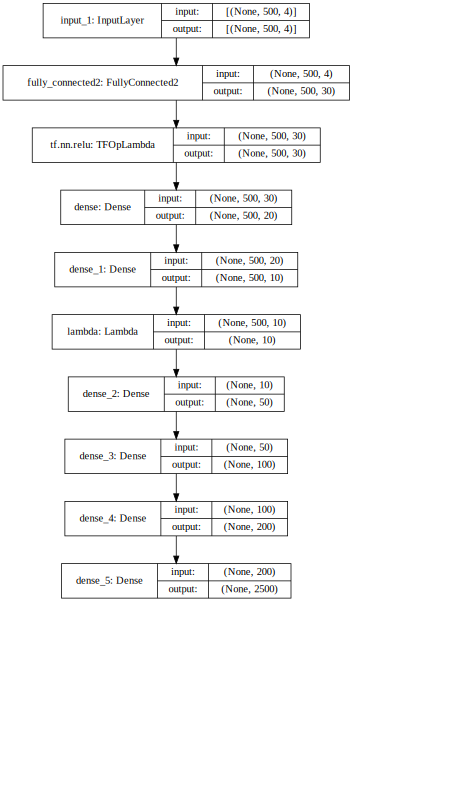

In [12]:
model.summary()

SVG(
    tf.keras.utils.model_to_dot(model, show_shapes=True).create(prog='dot',
                                                                format='svg'))
                                                         
#tf.keras.utils.plot_model(model,
#                          to_file='Résultats/Résultats 2/model_multiple_circles.pdf',
#                          show_shapes=True)

### Training the NN 

In [43]:
history = model.fit(new_data_train,
                    PI_train,
                    epochs=100,
                    validation_data=(new_data_test, PI_test))


Epoch 1/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/

32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 84/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 85/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 86/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 87/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 88/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 89/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 90/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 91/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 92/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 93/100


We can save the model

In [46]:
model.save('Saved_Model/model_withney_embedding_dynamical_syst')

INFO:tensorflow:Assets written to: Saved_Model/model_withney_embedding_dynamical_syst/assets


### Study the results to see how the training went 

In [44]:
prediction = model.predict(new_data_test)

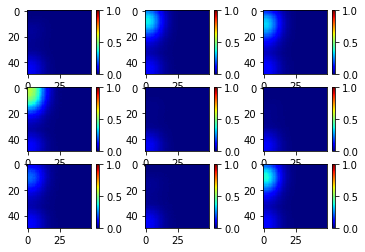

In [45]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(prediction[20 + i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    
plt.suptitle('The corresponding predicted PI')
#plt.savefig("Résultats/Résultats 3/withney_predicted.pdf")

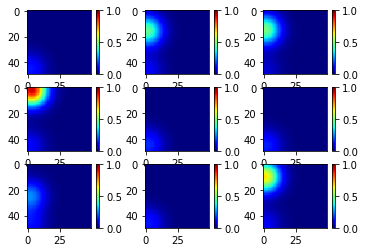

In [39]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(PI_test[20 + i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()

plt.suptitle('The corresponding true PI')
#plt.savefig("Résultats/Résultats 3/withney_true.pdf")

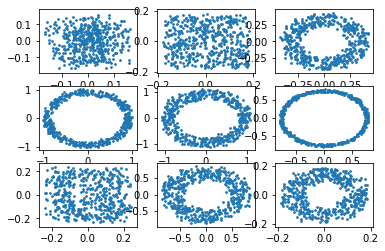

In [61]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_test[20 + i, :, 0], data_test[20 + i, :, 1], s=3)

plt.suptitle('The corresponding point cloud')
#plt.savefig("Résultats/Résultats 2/multiple_circles.pdf")

### Plot of the evolution of the loss

In [58]:
loss = model.evaluate(new_data_test, PI_test, verbose=1)

4/4 [==============================] - 0s 3ms/step - loss: 0.0061


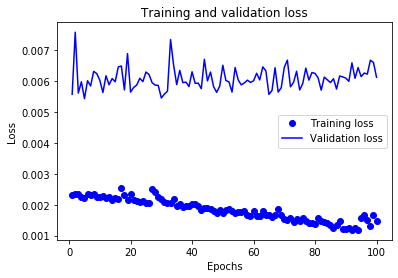

In [56]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs[:], loss[:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[:], val_loss[:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.savefig("Résultats/Résultats 2/training_loss.pdf")
plt.show()